## Estudio Espectro de rayos X

### Requirements

In [173]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle

from scipy.optimize import curve_fit
from scipy.signal import welch

# Añadir el directorio raíz del proyecto al sys.path
PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from hyper_velocity_stars_detection.jobs.utils import load_project, read_catalog_file
from hyper_velocity_stars_detection.cluster_detection.cluster_detection import get_main_cluster

PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 154362.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16353.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16353.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24125.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 1 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 2269
	 - Volumen total del cluster 0: 1175.
	 - Volumen

**REVISAR SI HAY DATOS DUPLICADOS EN LOS FITS, ES DECIR, CONTEOS CON LA MISMA FECHA Y SEGUNDO**

In [66]:
data = project.xrsource.lightcurves.get_data("EMOS2")
data

,time,obs_id,rate,rate_err,rate_raw_err,back,back_err,time_s
35,2019-04-07 20:10:21,0679180301,0.219629,0.077677,0.081036,0.011635,0.003359,0.0
36,2019-04-07 20:11:01,0679180301,0.174786,0.067991,0.071504,0.013607,0.003513,40.0
37,2019-04-07 20:11:41,0679180301,0.039548,0.039948,0.044014,0.018180,0.004065,80.0
38,2019-04-07 20:12:21,0679180301,0.169362,0.067680,0.071529,0.016330,0.003849,120.0
39,2019-04-07 20:13:01,0679180301,0.149587,0.063406,0.066920,0.013611,0.003514,160.0
...,...,...,...,...,...,...,...,...
1343,2019-04-08 00:33:03,0679180301,0.046016,0.043123,0.047907,0.010698,0.004784,15762.0
1344,2019-04-08 00:33:33,0679180301,0.054512,0.044055,0.047757,0.006412,0.003702,15792.0
1345,2019-04-08 00:34:03,0679180301,0.054580,0.044110,0.047817,0.006420,0.003706,15822.0
1346,2019-04-08 00:34:33,0679180301,0.122050,0.063841,0.067549,0.006422,0.003708,15852.0


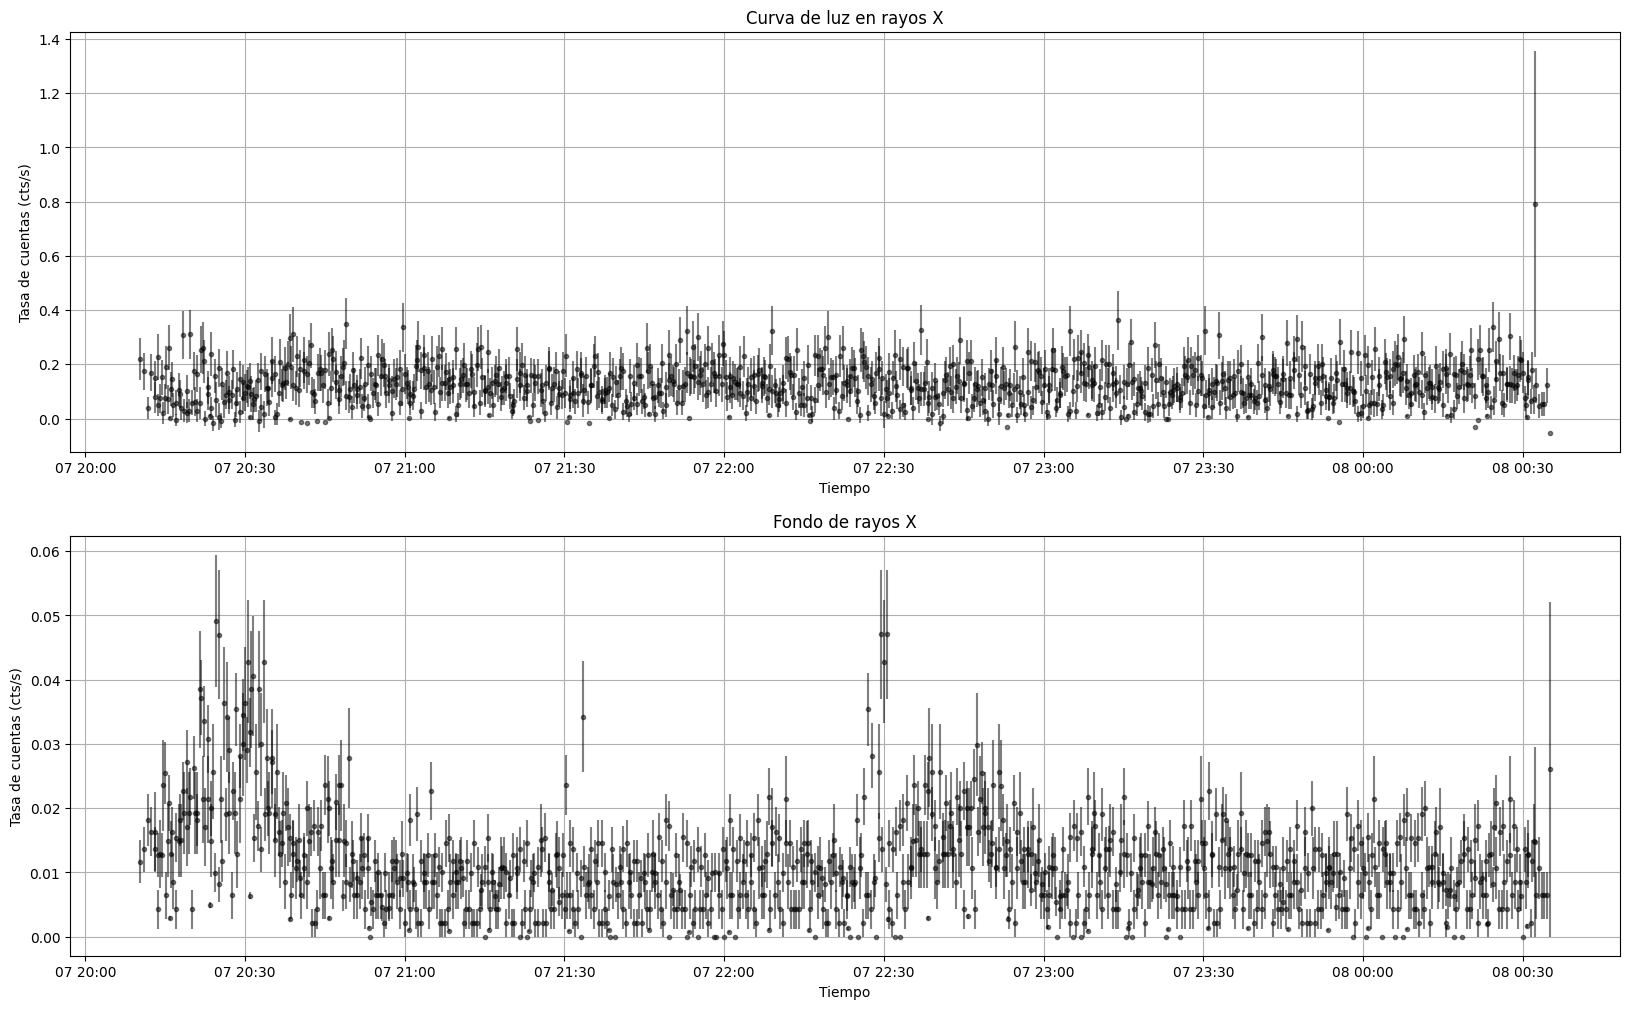

In [67]:
sensors_fits = project.xrsource.lightcurves.plot("EMOS2")

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Break Timescale: 4.65 s'}, xlabel='Frequency (Hz)', ylabel='Power Spectral Density'>)

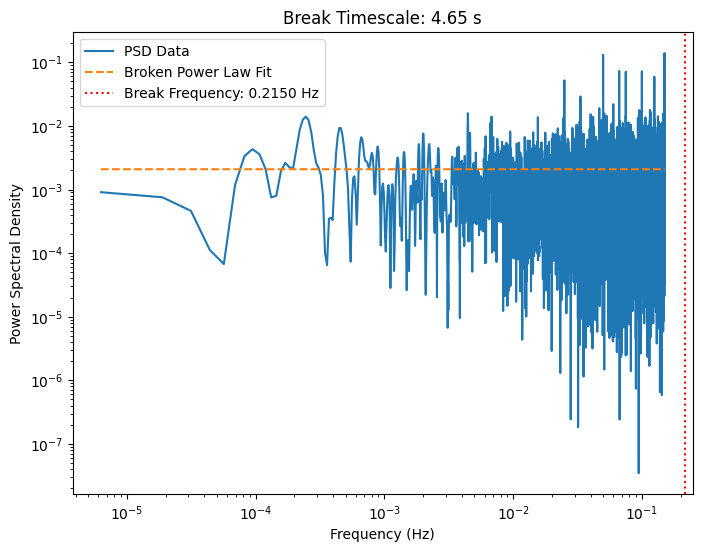

In [68]:
project.xrsource.lightcurves.plot_power_law("EMOS2", "ls", 256)

In [69]:
time = data.time_s.values
rate = data.rate.values
rate_err = data.rate_err.values
rate_err[rate_err == 0] = rate_err[rate_err > 0].min() / 10

In [81]:
f_min = data.groupby(["obs_id"]).agg({"time_s": lambda x: 1/(x.max() - x.min())}).min().values[0]
#f_min = 1 / (data.time_s.max() - data.time_s.min())
f_max = 1 / (2 * np.diff(data.time_s.unique()).min())
ls = LombScargle(time, rate)
frequency, power = ls.autopower(
    method='chi2', 
    method_kwds=None, 
    normalization="psd", 
    samples_per_peak=10, 
    nyquist_factor=10, 
    minimum_frequency=f_min, 
    maximum_frequency=None)


frequency.min(),frequency.max(), frequency.shape

(np.float64(6.29643621710112e-05), np.float64(0.30034000755572343), (47691,))

In [84]:
N = 500000
frequency = np.linspace(f_min, frequency.max(), N)
power = ls.power(frequency, method="chi2", normalization="psd")

[1. 1. 1. ... 1. 1. 1.]


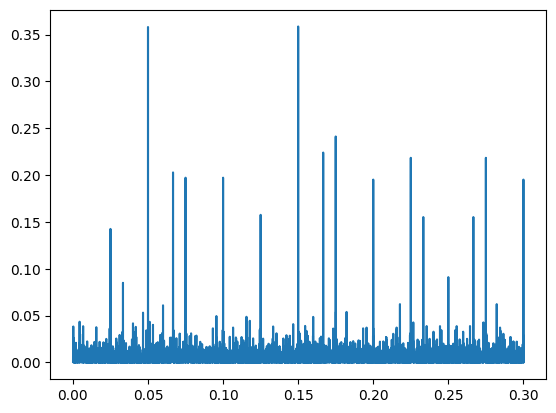

In [85]:
print(ls.false_alarm_probability(power))
plt.plot(frequency, power)

In [86]:
1/ best_frequency / 3600

np.float64(0.0018518296332497783)

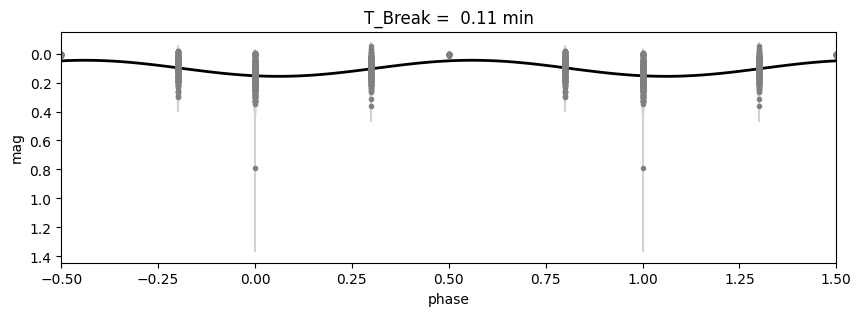

In [92]:
fig, ax = plt.subplots(figsize=(10, 3))

phase_model = np.linspace(-0.5, 1.5, 100)
best_frequency = frequency[np.argsort(power)[-6]]
phase = (time * best_frequency) % 1
mag_model = ls.model(phase_model / best_frequency, best_frequency)

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, rate, rate_err, fmt='.',
                color='gray', ecolor='lightgray', capsize=0);

ax.set_title(f"T_Break = {1/ best_frequency / 60 : .2f} min")
ax.plot(phase_model, mag_model, '-k', lw=2)
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase',
       ylabel='mag')
ax.invert_yaxis()

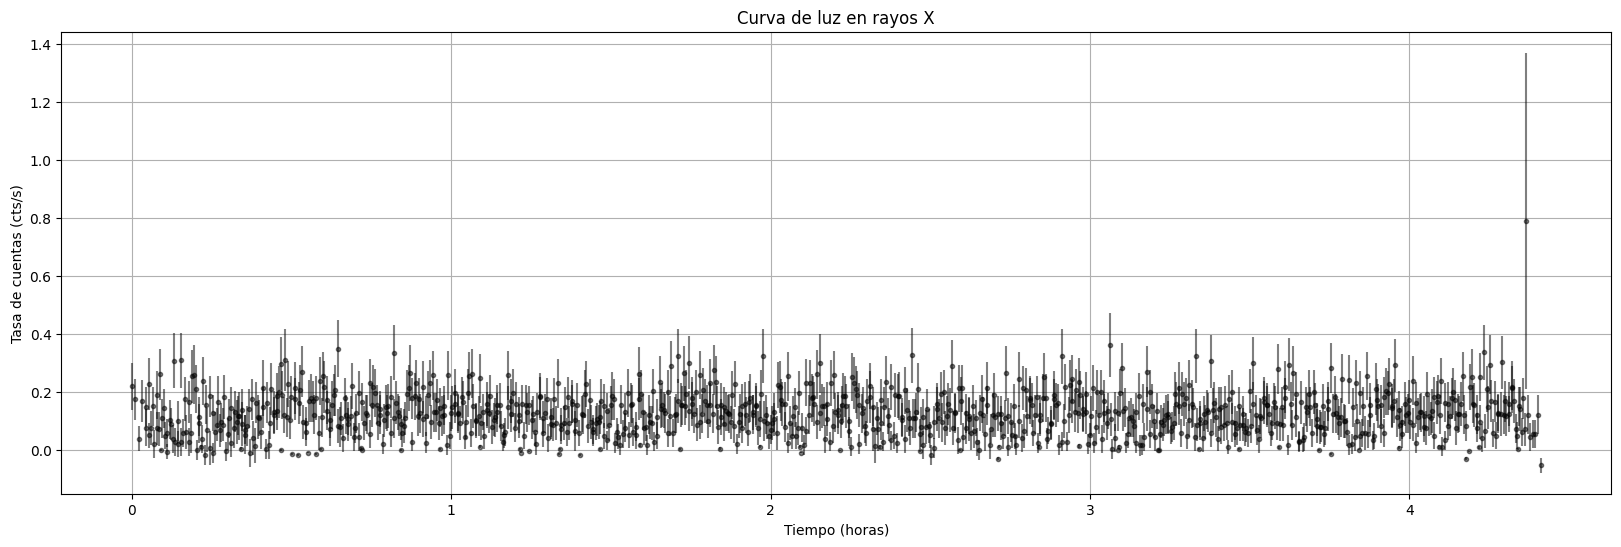

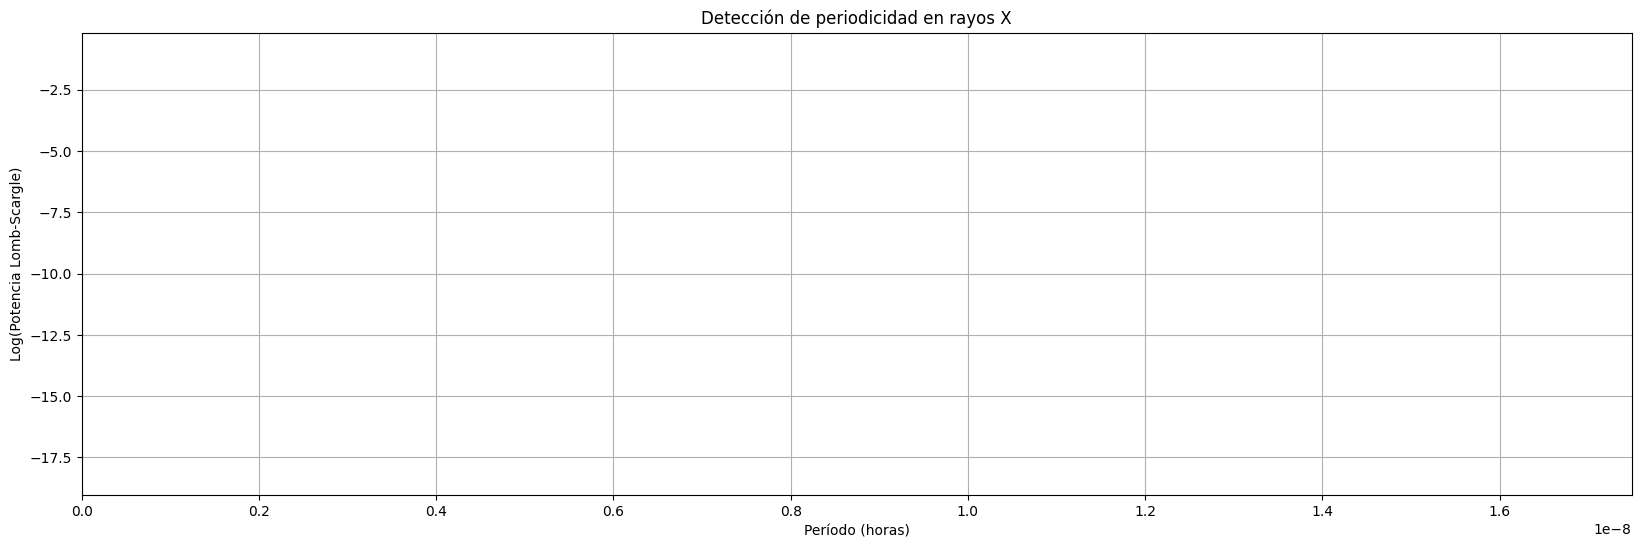

In [78]:
time = data.time_s.values
rate = data.rate.values
rate_err = data.rate_raw_err.values
rate_err[rate_err == 0] = rate_err[rate_err > 0].min() / 10

# Aplicar la Transformada Lomb-Scargle
# frequency, power = LombScargle(time, rate).autopower()

# back = data.back.values
# back_err = data.back_err.values

# n_simuls = 100
# frequencies_simuls = np.zeros((frequency.size, n_simuls))
# power_simuls = np.zeros((frequency.size, n_simuls))
# for simul in range(n_simuls):
#     rate_simul = np.random.normal(loc=rate, scale=rate_err)
#     frequencies_simuls[:, simul],  power_simuls[:, simul]=  LombScargle(time, rate_simul).autopower()


# frequency = frequencies_simuls.mean(axis=1)
# power = power_simuls.mean(axis=1)

# Convertir frecuencia a período en horas
period = 1 / frequency / 3600

# Graficar la curva de luz
plt.figure(figsize=(20, 6))
plt.errorbar(time / 3600, rate, yerr=rate_err, fmt='.k', alpha=0.5)  # Convertir tiempo a horas
plt.xlabel("Tiempo (horas)")
plt.ylabel("Tasa de cuentas (cts/s)")
plt.title("Curva de luz en rayos X")
plt.grid()


# Graficar el espectro de potencia de Lomb-Scargle
plt.figure(figsize=(20, 6))
plt.plot(period, np.log(power), 'k-')
plt.xlabel("Período (horas)")
plt.ylabel("Log(Potencia Lomb-Scargle)")
plt.title("Detección de periodicidad en rayos X")
plt.xlim(0, f_min / 3600)  # Limitar a períodos menores de 10 horas
plt.grid()

plt.show()

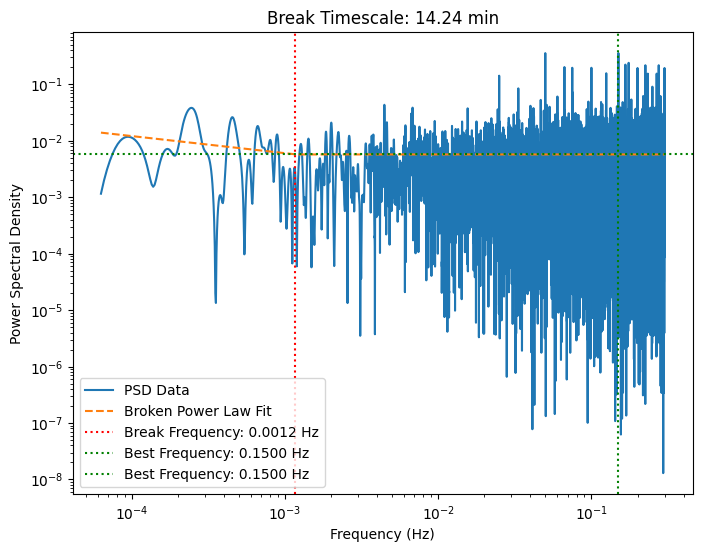

Break Timescale (T_B): 854.42 s


In [79]:
# Modelo de PSD con break
def broken_power_law(f, A, f_break, alpha_low, alpha_high):
    return A * (f/f_break)**(-alpha_low) *(f<f_break)  + A*(f/f_break)**(-alpha_high)*(f>=f_break)

# def broken_power_law(f, A, f_break, alpha_low, alpha_high):
#     return A * (f**(-alpha_low) )/ (1 + ((f / f_break)** (alpha_high - alpha_low)))

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [power.min(),best_frequency, 1, 2]
bounds=((0, frequency[1], 0, 0), (power[1:].max(),  2*frequency.max(), 2, 5))

# Ajuste del modelo al PSD
popt, pcov = curve_fit(broken_power_law, frequency[1:], power[1:], p0=p0, maxfev=100000, bounds=bounds)

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.plot(frequency, power, label="PSD Data")
plt.loglog(frequency, broken_power_law(frequency, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(1/T_B, color='r', linestyle=':', label=f'Break Frequency: {1/T_B:.4f} Hz')
plt.axvline(best_frequency, color='g', linestyle=':', label=f'Best Frequency: {best_frequency:.4f} Hz')
plt.axhline(power.mean(), color='g', linestyle=':', label=f'Best Frequency: {best_frequency:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B / 60:.2f} min")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")

In [61]:
popt, power.mean(), (power.mean() - popt[0]) / power.mean()

(array([4.74372039e-05, 2.12840425e-04, 8.97506898e-01, 2.21809437e-09]),
 np.float64(4.8066443569572535e-05),
 np.float64(0.013091039366552207))

In [63]:
# Calcular la Power Spectral Density (PSD) con la función de Welch
frequencies, psd = welch(rate, fs=1/np.diff(time).mean(), nperseg=258)
# Aplicar la Transformada Lomb-Scargle
frequencies, psd = LombScargle(time, rate, rate_err).autopower()

# Modelo de PSD con break
def broken_power_law(f, A, f_break, alpha_low, alpha_high):
    return A * (f/f_break)**(-alpha_low) *(f<f_break)  + A*(f/f_break)**(-alpha_high)*(f>=f_break)

# def broken_power_law(f, A, f_break, alpha_low, alpha_high):
#     return A * (f**(-alpha_low) )/ (1 + ((f / f_break)** (alpha_high - alpha_low)))

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [psd.mean(), frequencies[1], 1, 2]
bounds=((0, frequencies[1], 0, 0), (psd[1:].max(),  2*frequencies.max(), 2, 5))

# Ajuste del modelo al PSD
popt, pcov = curve_fit(broken_power_law, frequencies[1:], psd[1:], p0=p0, maxfev=100000, bounds=bounds)

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.plot(frequencies, psd, label="PSD Data")
plt.loglog(frequencies, broken_power_law(frequencies, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(1/T_B, color='r', linestyle=':', label=f'Break Frequency: {1/T_B:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B:.2f} s")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")

ValueError: array must not contain infs or NaNs

In [127]:
popt

(array([0.13449064, 0.02466615, 0.06815239, 2.69930596]),
 array([[ 4.91543521e-05, -3.72563255e-06, -1.83978375e-04,
         -1.11543778e-04],
        [-3.72563255e-06,  1.26430307e-06,  1.25392889e-05,
          2.92318167e-04],
        [-1.83978375e-04,  1.25392889e-05,  1.23577575e-03,
          1.12434766e-05],
        [-1.11543778e-04,  2.92318167e-04,  1.12434766e-05,
          1.54814622e-01]]))

/tmp/ipykernel_7495/3587519952.py:22: RuntimeWarning: divide by zero encountered in power
  return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)


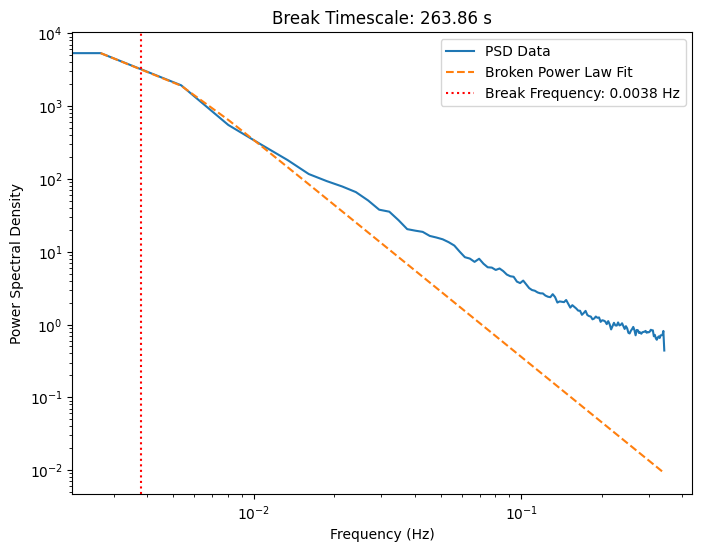

Break Timescale (T_B): 263.86 s


In [64]:
# Código de ejemplo

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.optimize import curve_fit

l_file = lfiles_candidate[1]


# Simulación de una curva de luz con ruido (en un caso real, se carga desde los datos XMM-Newton)
np.random.seed(42)
time = np.linspace(0, 50000, 5000) # 5000 puntos en 50000 segundos (~14h)
time = data["TIME"] 
flux = np.cumsum(np.random.normal(0, 1, size=len(time)))  # Señal aleatoria con tendencia

# Calcular la Power Spectral Density (PSD) con la función de Welch
frequencies, psd = welch(flux, fs=1/(time[1] - time[0]), nperseg=256)

# Función de ajuste para el PSD (Power Law con Break)
def broken_power_law(f, A, fb, alpha1, alpha2):
    return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [1e3, 1e-3, 1, 2]

# Ajuste del modelo al PSD
popt, _ = curve_fit(broken_power_law, frequencies[1:], psd[1:], p0=p0, maxfev=100000, bounds=(0,np.inf))

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.loglog(frequencies, psd, label="PSD Data")
plt.loglog(frequencies, broken_power_law(frequencies, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(popt[1], color='r', linestyle=':', label=f'Break Frequency: {popt[1]:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B:.2f} s")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")